# Task 1

`predictive_maintenance_dataset.csv` is a file that contains parameters and settings (`operational_setting_1`, `operational_setting_2`, `sensor_measurement_1`, `sensor_measurement_2`, etc.) for many wind turbines. There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. Your task is to create a model that, when fed with operational settings and sensor measurements (`unit_number` and `time_stamp` will *not* be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

## TOC

1. [Ideas](#Ideas)
2. [Assumption](#Assumptions)
1. [Importing libraries and dataset](#Importing-libraries-and-dataset)
3. [Explore dataset](#Explore-data)
2. [Feature engineering](#Feature-engineering)
3. [Feature scaling](#Feature-scaling)
4. [Basic EDA](#Basic-EDA)
5. [Prepare dataset -- balancing](#Dataset-for-model-selection)
5. [LSTM](#Fit-LSTM)
6. [Linear models, trees, balanced approach and multi-label problem](#Trying-Linear-models,-trees...)

## Ideas


1. **Feature engineering** -- create a column that says `possible_failure`, and mark it as 1 if there is failure within a 40 day window prior to the current observation for a turbine. This might make it easy to predict if the model might fail within 40 days.
1. LSTM using keras
2. Basic multi-label ensemble models using sci-kit learn  (https://arxiv.org/pdf/1609.08349.pdf) - Explore hamming distance to evaluate models and scikit learn functions (http://scikit.ml/api/classify.html#ensemble-approaches)
2. Survival analysis - Kaplan meir estimates

## Assumptions
1. For few turbines there are readings beyond today's date (18th July 2018). For the interest of this analysis, I am going to assume these are valid readings
2. Dealing with NAs in the dataset - Mean value imputation?
2. **NOT** assuming a continuous date range. If the manufacturers wanted to record readings every 2nd day instead of every day this method of prediction would still work. I use a column to capture date between observations for all readings.
4. If the window length of 40 isn't satisfied, is padding with 0's the best approach?
3. Dataset is imbalanced. Not certain if creating a balanced set is the best approach in this case. Might end up losing information from sensor data when I try undersampling, and oversampling will cause sensor value distribution to become skewed. Maybe trying ensemble might help (explore if you have time)

## Yet to do

1. Missing value imputation
2. Edge cases
2. More hyperparameter optimization
3. Overload predict function
3. More multi-label approaches

## Importing libraries and dataset

In [67]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from time import time
import missingno as msno
from collections import Counter
from itertools import product
from IPython.display import display, Markdown, Latex

# scikit learn models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#keras models
import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *
%matplotlib inline

RANDOM_STATE = 42 # setting seed

In [2]:
os.getcwd()

'/home/mojo/Github_personal/Canvass_codingchallenge/scripts'

In [3]:
pm_data = pd.read_csv('../data/predictive_maintenance_dataset.csv')
print(pm_data.shape)
pm_data.head()

(144203, 27)


,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,133.75,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,522.19,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,163.11,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,130.58,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,519.44,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682


## Explore data

### Imputation

In [4]:
numeric_cols = list(pm_data.select_dtypes(include=[np.number]).columns)
depend_cols = ['status']
drop_cols = ['unit_number','time_stamp']
cat_cols = ['operational_setting_3']
numeric_features = list(set(numeric_cols).difference(depend_cols + drop_cols + cat_cols))

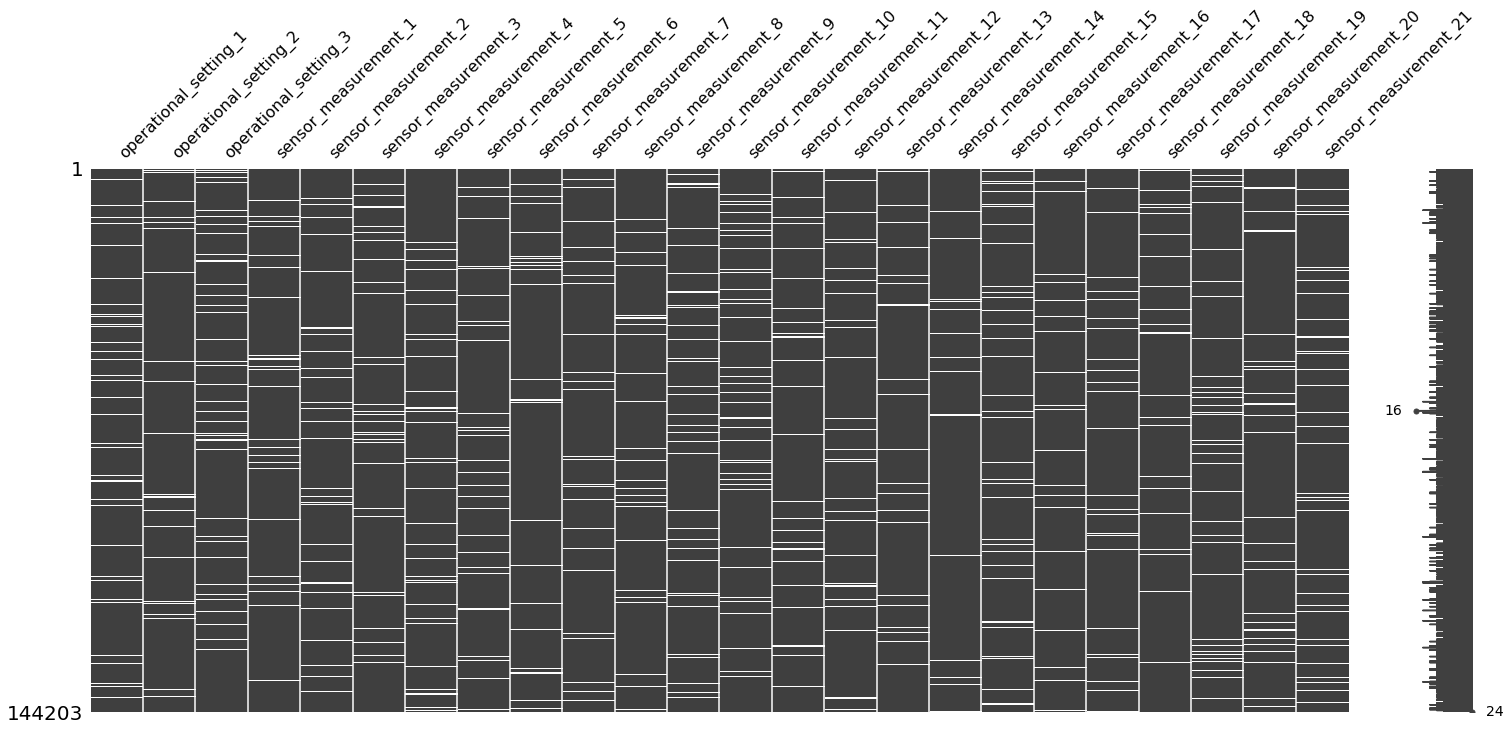

In [5]:
missingdata_df = pm_data.columns[pm_data.isnull().any()].tolist()
msno.matrix(pm_data[missingdata_df])

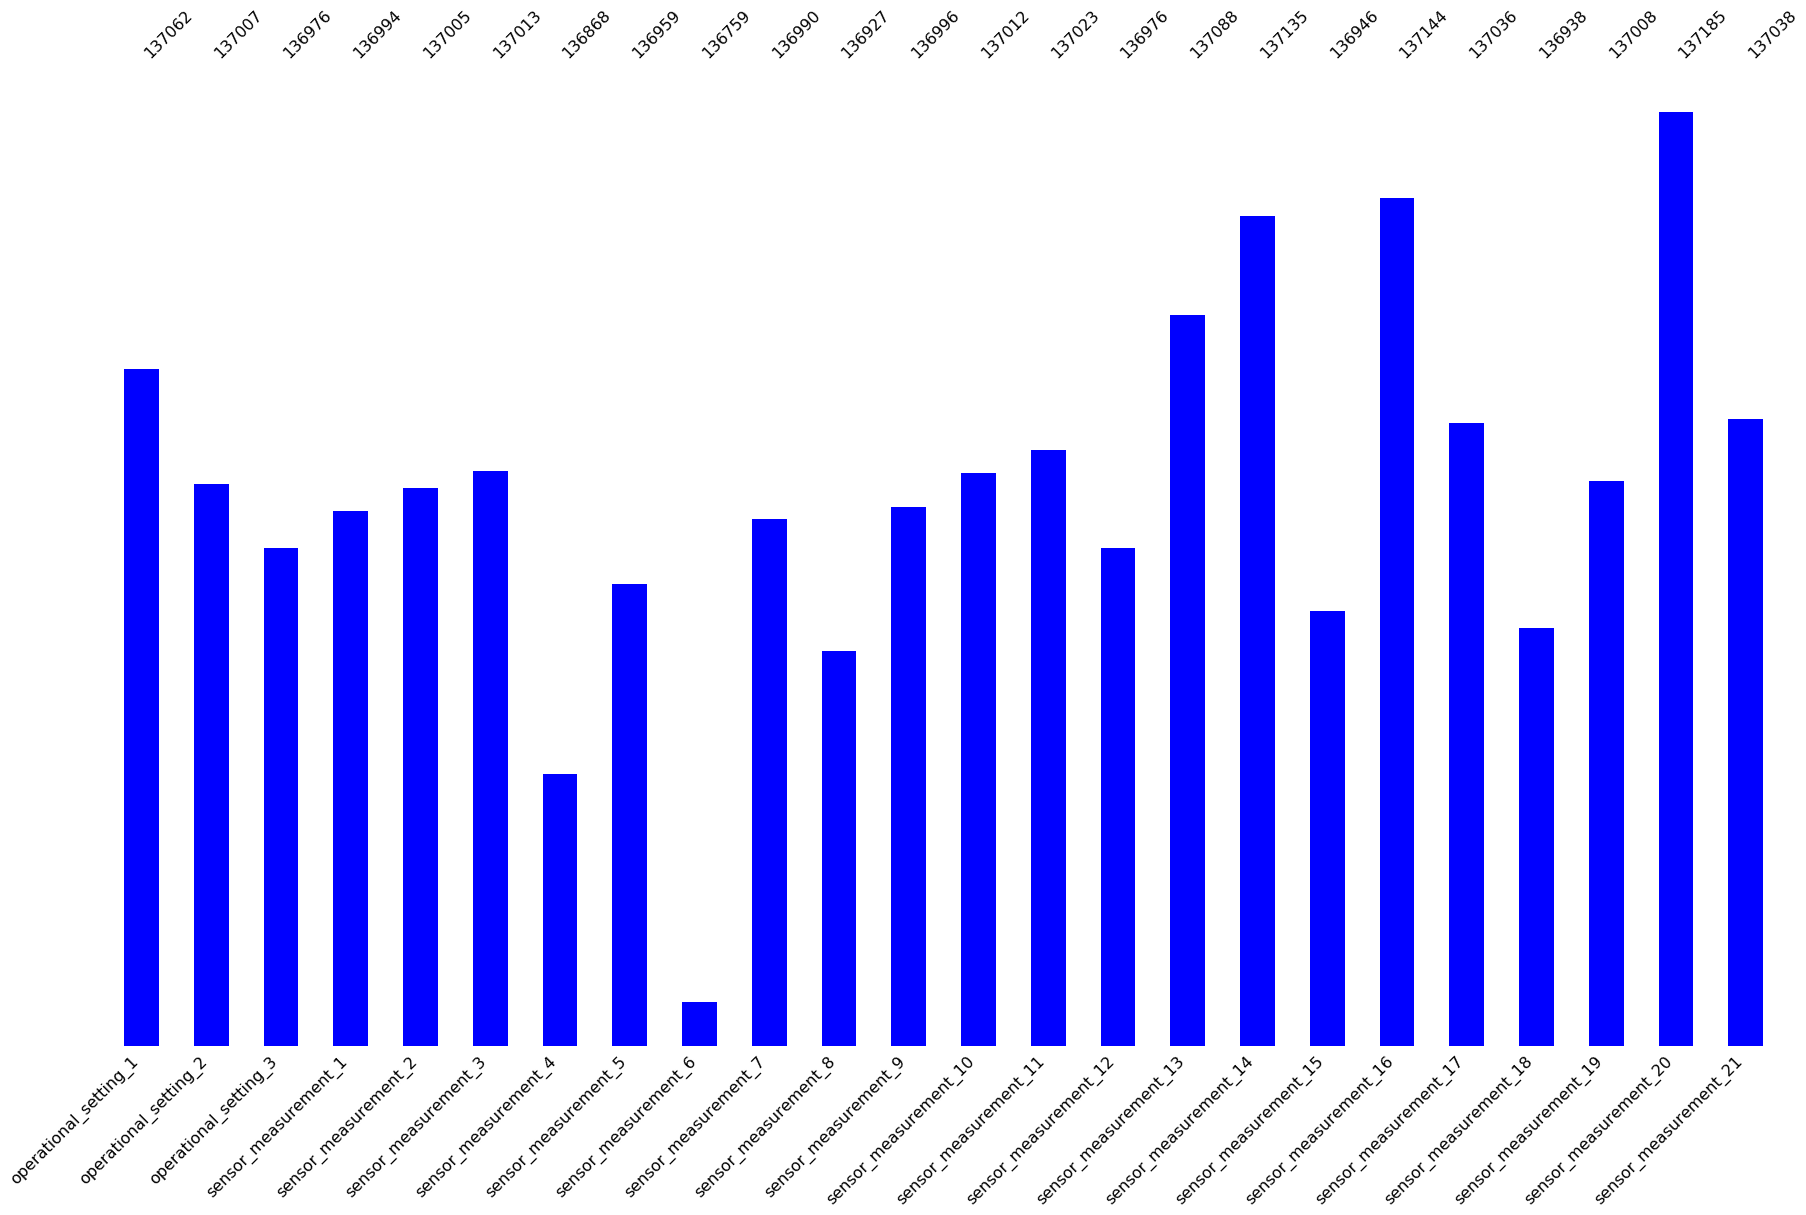

In [6]:
msno.bar(pm_data[missingdata_df], color="blue", log=True, figsize=(30,18))

**Trying to understand the source of missing data, it does not appear as if these records were excluded on purpose to affect results. Could be due to a sensor failure, or someone just forgetting to record readings. This would classify the missing data as Missing Completely at Random (MCAR) or Missing at Random (MAR).**

**Imputing values with median to avoid effect of outliers, and replacing categorical with the mode**

In [7]:
imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
imp_pm = pd.DataFrame(imp.fit_transform(pm_data.loc[:,numeric_features]))
imp_pm.columns = pm_data.loc[:,numeric_features].columns

In [8]:
pm_data.update(imp_pm,
              overwrite = False,
              raise_conflict = False)
pm_data.isnull().any()

unit_number              False
time_stamp               False
status                   False
operational_setting_1    False
operational_setting_2    False
operational_setting_3     True
sensor_measurement_1     False
sensor_measurement_2     False
sensor_measurement_3     False
sensor_measurement_4     False
sensor_measurement_5     False
sensor_measurement_6     False
sensor_measurement_7     False
sensor_measurement_8     False
sensor_measurement_9     False
sensor_measurement_10    False
sensor_measurement_11    False
sensor_measurement_12    False
sensor_measurement_13    False
sensor_measurement_14    False
sensor_measurement_15    False
sensor_measurement_16    False
sensor_measurement_17    False
sensor_measurement_18    False
sensor_measurement_19    False
sensor_measurement_20    False
sensor_measurement_21    False
dtype: bool

In [9]:
#replace categorical column with mode of columns, which is High in this case
op3_mode = pm_data['operational_setting_3'].mode()[0]
if not pd.isnull(op3_mode):
    print('Replacing NAs with mode:', op3_mode)
    pm_data['operational_setting_3'].fillna(op3_mode, inplace=True)
pm_data['operational_setting_3'].unique()

Replacing NAs with mode: High


array(['High', 'Low'], dtype=object)

In [10]:
pm_data.isnull().any()

unit_number              False
time_stamp               False
status                   False
operational_setting_1    False
operational_setting_2    False
operational_setting_3    False
sensor_measurement_1     False
sensor_measurement_2     False
sensor_measurement_3     False
sensor_measurement_4     False
sensor_measurement_5     False
sensor_measurement_6     False
sensor_measurement_7     False
sensor_measurement_8     False
sensor_measurement_9     False
sensor_measurement_10    False
sensor_measurement_11    False
sensor_measurement_12    False
sensor_measurement_13    False
sensor_measurement_14    False
sensor_measurement_15    False
sensor_measurement_16    False
sensor_measurement_17    False
sensor_measurement_18    False
sensor_measurement_19    False
sensor_measurement_20    False
sensor_measurement_21    False
dtype: bool

### Analyze output

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7fb5dcc88>]], dtype=object)

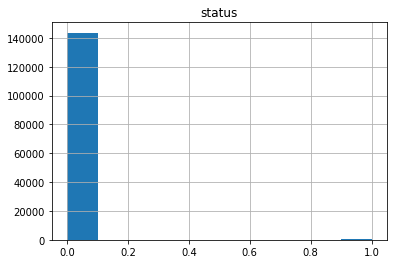

In [11]:
pm_data.loc[:,depend_cols].hist()

In [12]:
pm_data.status.value_counts()

0    143570
1       633
Name: status, dtype: int64

In [13]:
print("Ratio of minority to majority class is {:.3f}%".format(633/143570 * 100))

Ratio of minority to majority class is 0.441%


**We notice the imbalance in the dataset. This is expected because failures of turbines are usually far and few. To fit machine learning models that can accurately predict failure this dataset would have to be balanced.**

**This [paper](http://www.ele.uri.edu/faculty/he/PDFfiles/ImbalancedLearning.pdf) explains the concept of imbalance and how it might be beneficial to create a balanced dataset to improve classification accuracy. Also, it explains metrics such as recall and precision that can be used to help evaluate performance of a model, instead of the accuracy.**

**The paper also delves into Cost-sensitive method for imbalanced datasets. In this method, instead of creating balanced data distributions through different sampling strategies, cost=sensitive learning targets the imbalanced learning problem by using different cost matrices that describe the costs for misclassifying any particular data example. This can be achieved using parameters in the sci-kit learn model.**

**One-class learning method is something that has worked in the past as well. This involves learning feature importance for a single class rather than differentiating between classes like traditional approaches. This might be particularly useful in dealing with extremely imbalanced data sets with high feature space dimensionality.**

**After Feature engineering, check if there is still a class imbalance in the dataset.**


### Basic EDA

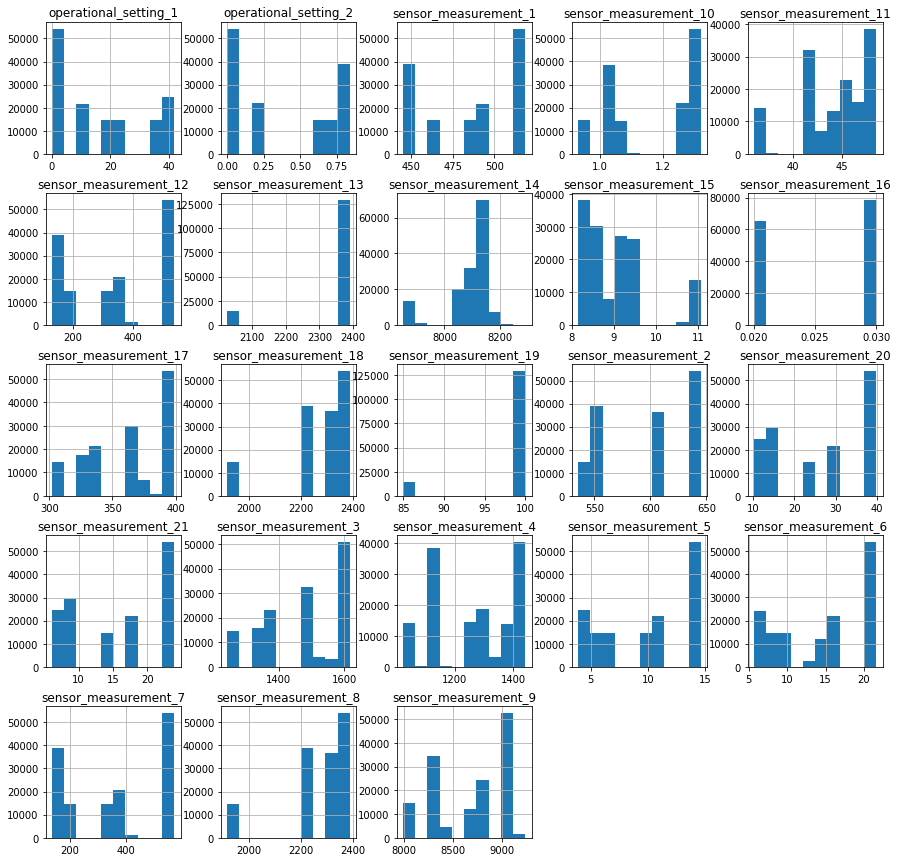

In [14]:
#dist of features
pm_data.loc[:,(numeric_features)].hist(figsize = (15,15))
plt.show()

Text(0.5,1,'Pairwise correlation')

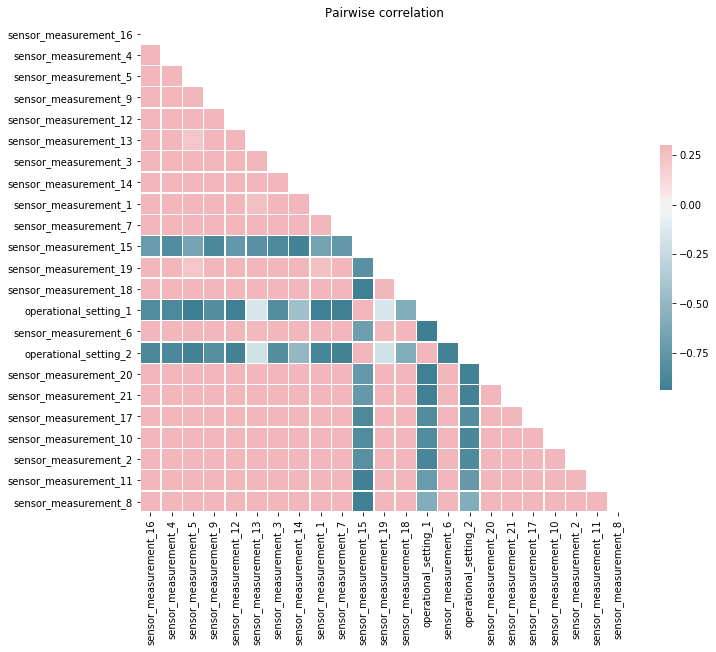

In [15]:
# source for code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
d = pm_data.loc[:,numeric_features]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Pairwise correlation')

**We notice 3 columns that stand out in this graph - Operational settings 1, settings 2 and sensor measurement 15 columns. Worth exploring how these columns affect the results, and checking for possible collinearity issues.**

In [16]:
# # removing NAs drastically drops count. Try imputation with mean value of sensor
# # check if operation needs to be performed. Losing out on valuable information
# pm_data.dropna(inplace = True)
# pm_data.shape

## Feature engineering

#### Calculate lag dates

In [17]:
pm_data['time_stamp'] = pd.to_datetime(pm_data.time_stamp)
pm_data.sort_values(['unit_number','time_stamp'], inplace=True)
pm_data.reset_index(inplace=True)

In [18]:
# feature engineering of categorical variable
pm_data = pd.concat([pm_data.drop('operational_setting_3', axis = 1),
                    pd.get_dummies(pm_data.operational_setting_3,
                                   prefix = 'operational_setting_3')[['operational_setting_3_High']]],
                    axis = 1).drop('index', axis = 1)

In [19]:
# take 2 dates and compute the difference
pm_data.sort_values(['unit_number','time_stamp'], inplace=True)
def get_date(date):
    
    date1 = date['time_stamp']
    date2 = date['time_stamp_lag']
    
    # first day
    if str(date2) == 'NaT':
        return 1
    
    # change of year
    if date1 < date2:
        return (date1 + 365) - date2
    
    return (date1 - date2).days

In [20]:
# record observation count for each sensor
pm_data = pd.concat([pm_data,
                     pd.DataFrame(pm_data.groupby('unit_number').cumcount(), columns = ['obs_count'])]
                    , axis = 1)

In [21]:
# create lag dates
lag_dates = (pm_data[['unit_number','time_stamp']]
             .groupby('unit_number')
             .shift(1))
lag_dates = pm_data.join(lag_dates.rename(columns=lambda x: x+"_lag"))

# compute difference in days
time_diff = pd.DataFrame(lag_dates[['time_stamp','time_stamp_lag']].apply(get_date, axis = 1),
                         columns = ['obs_date'])

# append lag_dates to actual data
pm_data = pd.concat([pm_data, time_diff], axis = 1)

In [22]:
pm_final = pd.concat([
            (pm_data[['unit_number','time_stamp','obs_date']]
            .groupby(['unit_number','time_stamp'])
            .sum()
            .groupby(level=[0])
            .cumsum()
            .reset_index()[['obs_date']]),
            pm_data.rename(columns = {'obs_date':'date_bw_obs'}).reset_index().drop('index', axis = 1)
          ], axis = 1
         )
pm_final.head(13)

,obs_date,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,obs_count,date_bw_obs
0,1,2,2017-04-01 12:00:00,0,-0.0018,0.0006,518.67,641.89,1583.84,1391.28,...,8.39050,0.03,391.0,2388.0,100.0,38.94,23.4585,1,0,1
1,2,2,2017-04-02 12:00:00,0,0.0043,-0.0003,518.67,641.82,1587.05,1393.13,...,8.41670,0.03,368.0,2388.0,100.0,39.06,23.4085,1,1,1
2,3,2,2017-04-03 12:00:00,0,0.0018,0.0003,518.67,641.55,1588.32,1398.96,...,8.38020,0.03,391.0,2388.0,100.0,39.11,23.4250,1,2,1
3,4,2,2017-04-04 12:00:00,0,0.0035,-0.0004,518.67,641.68,1584.15,1396.08,...,8.40180,0.03,391.0,2388.0,100.0,39.13,23.5027,1,3,1
4,5,2,2017-04-05 12:00:00,0,0.0005,0.0004,518.67,641.73,1579.03,1402.52,...,8.38670,0.03,390.0,2388.0,100.0,39.18,23.4234,1,4,1
5,6,2,2017-04-06 12:00:00,0,-0.0010,0.0004,518.67,641.30,1577.50,1396.76,...,8.38000,0.03,392.0,2388.0,100.0,39.15,23.4270,1,5,1
6,7,2,2017-04-07 12:00:00,0,0.0001,-0.0002,518.67,642.03,1587.49,1400.65,...,8.39410,0.03,391.0,2388.0,100.0,39.10,23.4718,1,6,1
7,8,2,2017-04-08 12:00:00,0,0.0015,-0.0004,518.67,642.55,1590.41,1293.97,...,8.38610,0.03,391.0,2388.0,100.0,28.25,23.4381,1,7,1
8,9,2,2017-04-09 12:00:00,0,0.0017,-0.0004,518.67,641.98,1581.99,1395.01,...,8.38680,0.03,390.0,2388.0,100.0,39.06,23.4875,1,8,1
9,10,2,2017-04-10 12:00:00,0,10.0078,0.0002,518.67,606.52,1586.37,1394.86,...,8.39820,0.03,391.0,2388.0,100.0,28.25,23.6005,1,9,1


#### Generate label `status_within_40days` (This give possibility of failure within 40 days label)

In [23]:
# Check if there is a better method to generate this label..3 loops seems like overkill!
# Sample case: pm_final[pm_final.unit_number == 4]
window_size = 40
Status = [] # hold status
for i,j in pm_final[['unit_number','obs_date','status']].groupby('unit_number'):

    status = j['status'].values # store status for every turbine
    date_bw_obs = j['obs_date'].values # store observed date for a reading
    failure_status = status.copy() # update to 1 if it obs has occured within 40 days of failure
    failures = np.where(status)[0].tolist() # retrieve position of status = 1
    
    if any(failures):
        # in case of multiple failures, loop through all failures. set indicator of last failure and only 
        # start from there. Avoid overlapping!
        for i in failures:
            # Loop through dates between observations to check if it falls within 40 days of failure. 
            for date in range(min(i,window_size)):
                    if (date_bw_obs[i] - date_bw_obs[i - date]) < window_size:
                        failure_status[i - date] = 1
            
    Status = Status + failure_status.tolist()

In [24]:
pm_final['status_within_40'] = Status
pm_final.head()

,obs_date,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,obs_count,date_bw_obs,status_within_40
0,1,2,2017-04-01 12:00:00,0,-0.0018,0.0006,518.67,641.89,1583.84,1391.28,...,0.03,391.0,2388.0,100.0,38.94,23.4585,1,0,1,0
1,2,2,2017-04-02 12:00:00,0,0.0043,-0.0003,518.67,641.82,1587.05,1393.13,...,0.03,368.0,2388.0,100.0,39.06,23.4085,1,1,1,0
2,3,2,2017-04-03 12:00:00,0,0.0018,0.0003,518.67,641.55,1588.32,1398.96,...,0.03,391.0,2388.0,100.0,39.11,23.4250,1,2,1,0
3,4,2,2017-04-04 12:00:00,0,0.0035,-0.0004,518.67,641.68,1584.15,1396.08,...,0.03,391.0,2388.0,100.0,39.13,23.5027,1,3,1,0
4,5,2,2017-04-05 12:00:00,0,0.0005,0.0004,518.67,641.73,1579.03,1402.52,...,0.03,390.0,2388.0,100.0,39.18,23.4234,1,4,1,0


Text(0.5,1,'Distribution of cumulative date for readings')

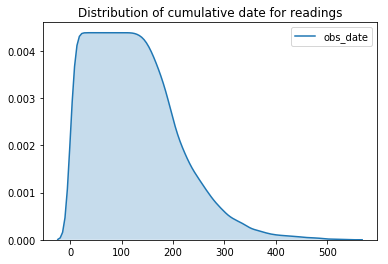

In [25]:
(sns.kdeplot(pm_final['obs_date'], shade=True)
    .set_title("Distribution of cumulative date for readings")
)

Text(0.5,1,'Distribution of reading counts for turbines')

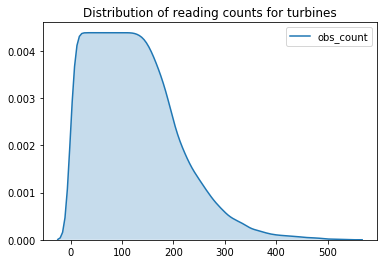

In [26]:
(sns.kdeplot(pm_final['obs_count'], shade=True)
   .set_title("Distribution of reading counts for turbines")
)

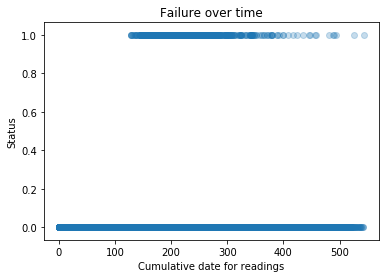

In [27]:
plt.scatter("obs_date","status", data=pm_final,marker='o', alpha = 0.25)
plt.xlabel("Cumulative date for readings")
plt.ylabel("Status")
plt.title('Failure over time')
plt.show()

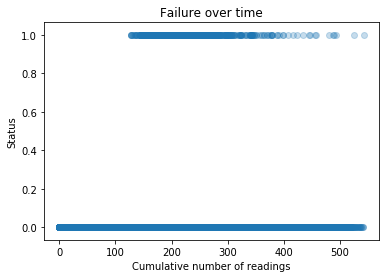

In [28]:
plt.scatter("obs_count","status", data=pm_final,marker='o', alpha = 0.25)
plt.xlabel("Cumulative number of readings")
plt.ylabel("Status")
plt.title('Failure over time')
plt.show()

## Feature scaling

In [29]:
# pick the feature columns 
source = ['operational', 'sensor']
target = list(pm_final.columns)
feature_names = [colname for colname in target 
                    if any(i in colname for i in source)] # check if there is a better way of doing this

scaling_features = feature_names.copy()
if 'operational_setting_3_High' in scaling_features: scaling_features.remove('operational_setting_3_High')

unscaled_features = [col for col in target if col not in scaling_features + ['status','status_within_40']]
print(scaling_features)
print()
print(unscaled_features)
        
stdsc = StandardScaler() # fit this on training data when encountered

['operational_setting_1', 'operational_setting_2', 'sensor_measurement_1', 'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_10', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_16', 'sensor_measurement_17', 'sensor_measurement_18', 'sensor_measurement_19', 'sensor_measurement_20', 'sensor_measurement_21']

['obs_date', 'unit_number', 'time_stamp', 'operational_setting_3_High', 'obs_count', 'date_bw_obs']


In [30]:
pm_final.status_within_40.value_counts()

0    118883
1     25320
Name: status_within_40, dtype: int64

In [31]:
print("Ratio of minority to majority class is {:.3f}%".format(25320/118883 * 100))

Ratio of minority to majority class is 21.298%


**NOTE: Minority to majority class ration is 20% and not 0.44% anymore**

In [32]:
## Export processed data
pm_final.to_csv('../results/processed_task1.csv')

### Findings
1. From the `Pairwise correlation` graph, there seems to be high correlation with sensor measurement 15 and the other sensor values
2. Operation setting 1 and 2 seem to be correlated with all the sensor values. Not aware of what readings represent to make any assumptions about the values.
4. The `Failure Over time` graph suggests that all failures occur 100 days after the first measurement was recorded, and most of them fail within 100-300 days of the first reading of the sensor.

**In this case, failure to predict a status of 1 could be detrimental. Hence trying to design a model with a high Recall score (false positives)**

### Should I be under sampling or over sampling? evaluate computation time and accuracy trade off 

> try using class weights first. This is computationally efficient

## Dataset for model selection

1. For LSTM, create a 3d array for the input - (samples x window_size x features) and a 2d array for the label
2. For other ensemble models, check if using `status_within_40` or creating a sequence of `status` yields better results

In [33]:
# Make a train/test split using 20% test size
X_train_valid, X_test, y_train_valid, y_test = train_test_split(pm_final.drop(['status','status_within_40','time_stamp'], axis = 1)
                                                    ,pm_final[['status_within_40']],
                                                    test_size=0.20,
                                                    random_state=RANDOM_STATE)

In [34]:
# Balance dataset using undersampling/oversampling
# Trying oversampling because LSTMs work better with larger than smaller datasets
rus=SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = rus.fit_sample(X_train_valid, y_train_valid.values.ravel())
X_resampled = pd.DataFrame(X_resampled, columns=X_train_valid.columns)
y_resampled = pd.DataFrame(y_resampled, columns=y_train_valid.columns)
X_resampled.shape

(190166, 28)

In [35]:
y_resampled.iloc[:,0].value_counts()

1    95083
0    95083
Name: status_within_40, dtype: int64

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled
                                                    , y_resampled
                                                    , test_size=0.20)

In [37]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(152132, 28)
(38034, 28)
(28841, 28)


In [38]:
print(y_train['status_within_40'].value_counts())
print(y_valid['status_within_40'].value_counts())
print(y_test['status_within_40'].value_counts())

0    76137
1    75995
Name: status_within_40, dtype: int64
1    19088
0    18946
Name: status_within_40, dtype: int64
0    23800
1     5041
Name: status_within_40, dtype: int64


In [39]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [40]:
class_weights = get_class_weights(y_train_valid['status_within_40'])
class_weights

{0: 1.0, 1: 4.688742048424478}

In [41]:
def bind_scaled_non_scaled(data, scaled_feat, unscaled_feat, model):
    """
    This function scales numeric features and binds other features to the matrix
    
    Args:
        data: Features and label data
        scaled_feat: Feature column names to be scaled
        unscaled_feat: Columns which do not have to be scaled 
        model: Method to be used for scaling numeric values (default is Standard scaler)
    
    Output:
        bind_data: pandas dataframe
            Data frame consisting of scaled and unscaled features for model
    
    """
   
    scaled_data = model.transform(data.loc[:,scaled_feat])
    bind_data =  pd.concat([pd.DataFrame(scaled_data, columns = scaled_feat), 
                            data.loc[:,unscaled_feat].reset_index().drop(data.loc[:,unscaled_feat].columns[0], axis = 1)],
                           axis = 1
                          )
    return bind_data

In [42]:
stdsc.fit(X_train.loc[:,scaling_features])

X_train = bind_scaled_non_scaled(X_train, scaling_features, unscaled_features, stdsc)
X_valid = bind_scaled_non_scaled(X_valid, scaling_features, unscaled_features, stdsc)
X_test = bind_scaled_non_scaled(X_test, scaling_features, unscaled_features, stdsc)

## Fit LSTM

LSTM design
1. Input dim -- input shape is equal to the window size and features(24) for this window size(40).
2. Output dim -- probabilities of failure for 40 future days. If prob > 0.5 it can classified as 1 else 0.

In [43]:
# slide a window of 40 and capture feature and status information
# do this for total number of rows in data - size of window(40)
# check if this should be done, or the window itself has to move by 40 per iteration
def pre_process_data_LSTM(data, feature_columns, target_label, window_size, resample = False):
    X,Y = [],[]
#     data = data.reset_index()
    for i in range(data.shape[0]-window_size-1): 
        X_block = np.array(data.loc[i:(i+window_size-1),feature_columns])
        Y_block = np.array(data.loc[i,target_label])
        
        # padding
        if X_block.shape[1] < (window_size - 1):
            X_block[X_block.shape[1]:window_size-1] = 0
#             Y_block[X_block.shape[1]:window_size-1] = 0

        X.append(X_block)
        Y.append(Y_block)
    return np.array(X),np.array(Y)

In [44]:
window_size = 40
t0 = time()

X_tr_ls, y_tr_ls = pre_process_data_LSTM(pd.concat([X_train.reset_index(drop = True),
                                                      y_train.reset_index(drop = True)], axis = 1), 
                                                     feature_names,
                                                     'status_within_40',
                                                     window_size)
X_val_ls, y_val_ls = pre_process_data_LSTM(pd.concat([X_valid.reset_index(drop = True),
                                                      y_valid.reset_index(drop = True)], axis = 1), 
                                                     feature_names,
                                                     'status_within_40',
                                                     window_size)
X_test_ls, y_test_ls = pre_process_data_LSTM(pd.concat([X_test.reset_index(drop = True),
                                                      y_test.reset_index(drop = True)], axis = 1), 
                                                     feature_names,
                                                     'status_within_40',
                                                     window_size)
print("time taken: {:.3f} seconds".format(time() - t0))

time taken: 256.265 seconds


In [45]:
print("Shape of input",X_tr_ls.shape)
print("Shape of output",y_tr_ls.shape)

Shape of input (152091, 40, 24)
Shape of output (152091,)


In [46]:
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
# precision and recall were removed from keras, here's the commit https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [47]:
# Reference to use F1-score later - https://stackoverflow.com/questions/45411902/how-to-use-f1-score-with-keras-model

In [50]:
t0 = time()    

# define Keras features
numb_features = X_tr_ls.shape[2]
numb_out = 1
window_size = 40

model = Sequential()

model.add(LSTM(
         input_shape=(window_size, numb_features),
         units=50,
         return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(
          units=200,
          return_sequences=False))
# model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
# model.add(Dense(units=1, activation='sigmoid'))
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',recall,precision,auc_roc])

print(model.summary())

# fit the network
X_tr_val = np.concatenate((X_tr_ls,X_val_ls), axis = 0)
y_tr_val = np.concatenate((y_tr_ls,y_val_ls), axis = 0)

model.fit(X_tr_val, y_tr_val.reshape(-1,1), epochs=20, batch_size=256, verbose=1, validation_split = 0.1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=0, mode='auto')]
          )

print("Total time to run model", (time() - t0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 40, 50)            15000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               200800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 216,001
Trainable params: 216,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 171075 samples, validate on 19009 samples
Epoch 1/20
171075/171075 [==============================] - 328s 2ms/step - loss: 0.6932 - acc: 0.4993 - recall: 0.4328 - precision: 0.4897 - auc_roc: 0.4983 - val_loss: 0.6932 - val_acc: 0.4970 - val_recall: 0.8400 - val_precision: 0.4975 - val_auc_roc: 0.4985
Epoch 2/20
171075/171075 [==============================] - 345s 2ms/step - loss: 

In [51]:
y_pred = model.predict_classes(X_test_ls)

In [52]:
print('Test classifcation report')
print(classification_report(y_test_ls,y_pred.ravel()))

Test classifcation report
             precision    recall  f1-score   support

          0       0.96      0.86      0.91     23766
          1       0.55      0.81      0.66      5034

avg / total       0.89      0.85      0.86     28800



In [53]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("../models/model_Task1_LSTM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../models/model_Task1_LSTM.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

## Trying Linear models, trees...

For `status_within_40` try Basic linear models/trees

Try balancing dataset using undersampling,oversampling and both. Then try fitting the models again

In [54]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(152132, 29)
(38034, 29)
(28841, 29)


In [59]:
X_tr = X_train.loc[:,feature_names]
X_val = X_valid.loc[:,feature_names]
X_te = X_test.loc[:,feature_names]
y_tr = np.array(y_train.iloc[:,0])
y_val = np.array(y_valid.iloc[:,0])
y_te = np.array(y_test.iloc[:,0])

In [60]:
names = ["Nearest Neighbors", "Linear SVC", "Decision Tree", 
         "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "XG Boost"]

In [65]:
classifiers = [
    KNeighborsClassifier(n_neighbors= 3,n_jobs= -1),
    LinearSVC(C=0.02, class_weight='balanced'),
    DecisionTreeClassifier(max_depth=7, class_weight='balanced'),
    RandomForestClassifier(max_depth=10, n_estimators=20, class_weight='balanced'),
    MLPClassifier(hidden_layer_sizes = (50,100),activation = 'logistic', alpha=0.01),
    AdaBoostClassifier(algorithm="SAMME"),
    GaussianNB(),
    XGBClassifier(max_depth=7,
                  sub_sample = 0.9, 
                  gamma=2.5,
                  eval_metric = "auc",
                  objective = "binary:logitraw",
                  nthread = 4)]

In [66]:
import warnings
warnings.filterwarnings('ignore')
for name, clf in zip(names, classifiers):
    print('Fitting data for {0} model...'.format(name))
    clf.fit(X_tr, y_train)
    print('Prediciting results for {0} model...'.format(name))
    y_pred_val = clf.predict(X_val)
    y_pred_test = clf.predict(X_te)
    target_names = ['Running', 'Failure']
    display(Markdown('**Validation results**'))
    print(classification_report(y_valid, y_pred_val, target_names=target_names))
    display(Markdown('**Validation results**'))
    print(classification_report(y_te, y_pred_test, target_names=target_names))

Fitting data for Nearest Neighbors model...
Prediciting results for Nearest Neighbors model...
Validation results
             precision    recall  f1-score   support

    Running       0.95      0.92      0.94     18946
    Failure       0.93      0.95      0.94     19088

avg / total       0.94      0.94      0.94     38034

Test result
             precision    recall  f1-score   support

    Running       0.95      0.93      0.94     23800
    Failure       0.70      0.79      0.74      5041

avg / total       0.91      0.91      0.91     28841

Fitting data for Linear SVC model...
Prediciting results for Linear SVC model...
Validation results
             precision    recall  f1-score   support

    Running       0.75      0.78      0.76     18946
    Failure       0.77      0.74      0.76     19088

avg / total       0.76      0.76      0.76     38034

Test result
             precision    recall  f1-score   support

    Running       0.93      0.78      0.85     23800
    Failur

### Findings

- All the models seem to perform poorly while predicting the failure class (low F1-score). I'm confident that this has to do with the imbalanced dataset. Try proceeding with Random forest after balancing the classes. Linear SVM and Random forest with `class_weights` parameter seems to yield a **high Recall**, at the cost of precision. This is better than the other models
- Random forest without balancing classes yields an average F1-score of `.45`

In [90]:
val_scores=[]
for trees in range(5,35,5):
    print("Fitting...")
    print("iter", trees//5)
    clf = RandomForestClassifier(max_depth=15, 
                                 n_estimators= trees,
                                 class_weight='balanced')
    validated = cross_val_score(clf, 
                                X_train_valid.loc[:,feature_names],
                                y_train_valid_40, 
                                cv = 10, 
                                scoring = 'f1')
    val_scores.append(validated)

Fitting...
iter 1
Fitting...
iter 2
Fitting...
iter 3
Fitting...
iter 4
Fitting...
iter 5
Fitting...
iter 6


In [91]:
val_scores = pd.DataFrame(val_scores, index= [i for i in range(5,35,5)] )

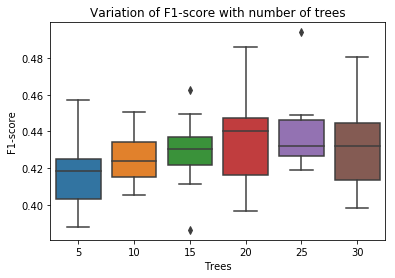

In [92]:
ax = sns.boxplot(data = val_scores.T)
ax.set(xlabel='Trees', ylabel='F1-score')
plt.title('Variation of F1-score with number of trees')
plt.show()

In [93]:
clf.fit(X_tr, y_train_40)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [94]:
from sklearn.externals import joblib
joblib.dump(clf, '../models/task1_random_forest.pkl') 

['../models/task1_random_forest.pkl']

In [571]:
# clf = joblib.load('../models/task2_model.pkl') 

### Using a balanced dataset

In [68]:
# source: http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/evaluation/plot_classification_report.html#sphx-glr-auto-examples-evaluation-plot-classification-report-py

In [73]:
from imblearn import over_sampling as os
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler,
                                     NearMiss,
                                     InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection)
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

In [74]:
RANDOM_STATE = 1234
from time import time
samplers = [RandomUnderSampler,
             NearMiss,
             InstanceHardnessThreshold,
             EditedNearestNeighbours,
             OneSidedSelection]

for sampler in samplers:
    t0 = time()
    print("Using " + str(sampler))
    sampler = sampler(random_state= RANDOM_STATE)
    clf = pl.make_pipeline(sampler, 
                           LogisticRegression(random_state=RANDOM_STATE))
    clf.fit(X_tr, y_tr)
    
    print("Predicting for " + str(sampler))
    # Test the classifier and get the prediction
    y_pred_val = clf.predict(X_val)

    # Show the classification report
    print(classification_report_imbalanced(y_val, y_pred_val))
    print("Time elapsed:", (time() - t0))

print("Completed evaluation")

Using <class 'imblearn.under_sampling.prototype_selection.random_under_sampler.RandomUnderSampler'>
Predicting for RandomUnderSampler(random_state=1234, ratio='auto', replacement=False,
          return_indices=False)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.74      0.75      0.82      0.74      0.55     19014
          1       0.38      0.75      0.74      0.50      0.74      0.56      4059

avg / total       0.84      0.74      0.75      0.77      0.74      0.55     23073

Time elapsed: 12.66941237449646
Using <class 'imblearn.under_sampling.prototype_selection.nearmiss.NearMiss'>
Predicting for NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3, random_state=1234,
     ratio='auto', return_indices=False, size_ngh=None, ver3_samp_ngh=None,
     version=1)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.80      0.70      0.86      0.75      0.57 

**Achieved highest recall and F1-score using Random under sampling** 

In [75]:
RANDOM_STATE = 1234
t0 = time()
print("Using " + str(sampler))
sampler =os.SMOTE(random_state=RANDOM_STATE)
clf = pl.make_pipeline(sampler, 
                       LogisticRegression(random_state=RANDOM_STATE))
clf.fit(X_tr, y_tr)

print("Predicting for " + str(sampler))
# Test the classifier and get the prediction
y_pred_bal =clf.predict(X_val)

# Show the classification report
print(classification_report_imbalanced(y_val, y_pred_bal))
print("Time elapsed:", (time() - t0))

Using OneSidedSelection(n_jobs=1, n_neighbors=None, n_seeds_S=1, random_state=1234,
         ratio='auto', return_indices=False, size_ngh=None)
Predicting for SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=1234, ratio='auto', svm_estimator=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.75      0.75      0.83      0.75      0.57     19014
          1       0.39      0.75      0.75      0.52      0.75      0.57      4059

avg / total       0.84      0.75      0.75      0.78      0.75      0.57     23073

Time elapsed: 42.43821954727173


**Achieved a recall of 0.85 and f-1 score of 0.4 on the validation set using Over-sampling**

## Multi-label problem approach

In [96]:
def make_y_series(data, groupby_col, target_col, window_size):
    """
    This function creates a 40 window time sequence of labels (status). Pads with 0s if length < window_size
    
    Args:
        data: input dataset
        groupby_col: Column to group by labels
        target_col: Label column
        window_size: Size of time series window
    
    Output:
        Y: numpy 2d matrix
            Matrix consisting of time series labels for each observation
    
    """
    Y = []
    
    # loop through each turbine data and append next 40 values
    for unit, value in data[[groupby_col,target_col]].groupby(groupby_col):
        data = value.status.values.tolist()
        
        for i in range(len(data)):
            Y_blocks = data[i: i + window_size]

            if len(Y_blocks) < window_size: # if the next 40 values aren't present, pad with 0s. Check if this approach is the best?
                Y_blocks[len(Y_blocks):(window_size - 1)] = [0] * (window_size - len(Y_blocks))
            Y.append(Y_blocks)

    return np.array(Y)

In [97]:
Y = make_y_series(pm_final, 'unit_number', 'status', 40)
Y.shape

(42076, 40)

In [115]:
# Make a train/test split using 20% test size
X_train, X_test, y_train, y_test = train_test_split(
                                                    pm_final.loc[:,scaling_features + ['operational_setting_3_High']],
                                                    Y,
                                                    test_size=0.20,
                                                    random_state = RANDOM_STATE)

In [135]:
# Binary relevenace..fitting separately on each column
# Try other approaches

In [133]:
from skmultilearn.problem_transform import BinaryRelevance

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(clf)

# train
classifier.fit(np.array(X_train), np.array(y_train))

# predict
predictions = classifier.predict(X_train)

In [134]:
print(classification_report(y_train, predictions))

             precision    recall  f1-score   support

          0       0.81      0.97      0.88       154
          1       0.61      1.00      0.75       152
          2       0.42      0.99      0.59       157
          3       0.38      0.98      0.55       163
          4       0.45      0.99      0.62       158
          5       0.41      0.97      0.58       156
          6       0.37      0.99      0.53       160
          7       0.42      0.96      0.59       150
          8       0.52      0.96      0.67       162
          9       0.48      0.94      0.64       143
         10       0.54      0.97      0.70       155
         11       0.48      0.98      0.65       148
         12       0.64      0.95      0.77       163
         13       0.58      0.94      0.72       154
         14       0.83      0.96      0.89       160
         15       0.83      0.99      0.90       169
         16       0.54      0.97      0.70       166
         17       0.61      0.95      0.74   